In this part of the code, we will define the directory path, import some needed libraries, and define some common constant parameters that we will often use in later parts of the project.

In [1]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data

#Define Directories for train, test & Validation Set
train_path = 'train'
test_path = 'test'
valid_path = 'val'

#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

#The dimension size of 500 or more than 500 with batch size greater than 16 may result in a crash as the RAM gets 
#completely used in such cases. A lower dimension size with greater batch size is one of the options to try.

## Data Preparation

### Data Augmentation

We will increase the size of the image training dataset artificially by performing some Image Augmentation technique.

Image Augmentation expands the size of the dataset by creating a modified version of the existing training set images that helps to increase dataset variation and ultimately improve the ability of the model to predict new images.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

Using the tensorflow.keras.preprocessing.image library, for the Train Set, we created an Image Data Generator that randomly applies defined parameters to the train set and for the Test & Validation set, we’re just going to rescale them to avoid manipulating the test data beforehand.

Defining some of the Image Data Generator parameters:-

rescale —Each digital image is created by a pixel with a value between 0 and 255. 0 in black, 255 in white. So rescale the scales array of the original image pixel values to be between [0,1] which makes the images contribute more equally to the overall loss. Otherwise, higher pixel range image results in greater loss and a lower learning rate should be used, lower pixel range image would require a higher learning rate.
shear_range — The shape of the image is the transformation of the shear. It fixes one axis and stretches the image at a certain angle known as the angle of the shear.
zoom_range — The image is enlarged by a zoom of less than 1.0. The image is more than 1.0 zoomed out of the picture.
horizontal_flip —Some images are flipped horizontally at random
vertical_flip — Some images are flipped vertically at random
roataion_range — Randomly, the image is rotated by some degree in the range 0 to 180.
width_shift_range — Shifts the image horizontally.
height_shift_range — Shifts the image vertically.
brightness_range — brightness of 0.0 corresponds to absolutely no brightness, and 1.0 corresponds to maximum brightness
fill_mode — Fills the missing value of the image to the nearest value or to the wrapped value or to the reflecting value.
These transformation techniques are applied randomly to the images, except for the rescale. All images have been rescaled.

### Loading Images

The Image Data Generator has a class known as flow from directory to read the images from folders containing images. Returns the DirectoryIterator typetensorflow.python.keras.preprocessing.image.DirectoryIterator.

Some of the parameters it takes in are defined below :-

<b>directory:</b> The first parameter used is the path of the train, test & validation folder that we defined earlier.

<b>target_size:</b> The target size is the size of your input images, each image will be resized to this size. We have defined the target size earlier as 500 x 500.

<b>color_mode:</b> If the image is either black and white or grayscale set to “grayscale” or if the image has three colour channels set to “rgb.” We’re going to work with the grayscale, because it’s the X-Ray images.

<b>batch_size:</b> Number of images to be generated by batch from the generator. We defined the batch size as 16 earlier. We choose 16 because the size of the images is too large to handle the RAM.

<b>class_mode:</b> Set “binary” if you only have two classes to predict, if you are not set to “categorical,” if you develop an Autoencoder system, both input and output are likely to be the same image, set to “input” in this case. Here we’re going to set it to binary because we’ve only got 2 classes to predict.

In [3]:
train = image_gen.flow_from_directory(
      train_path,
      target_size = (img_height, img_width),
      color_mode = 'grayscale',
      class_mode = 'binary',
      batch_size = batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size = (img_height, img_width),
      color_mode = 'grayscale',
      shuffle = False, #setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode = 'binary',
      batch_size = batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size = (img_height, img_width),
      color_mode = 'grayscale',
      class_mode = 'binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


Let’s take a look at some of the train set images that we obtained from the Data Augmentation

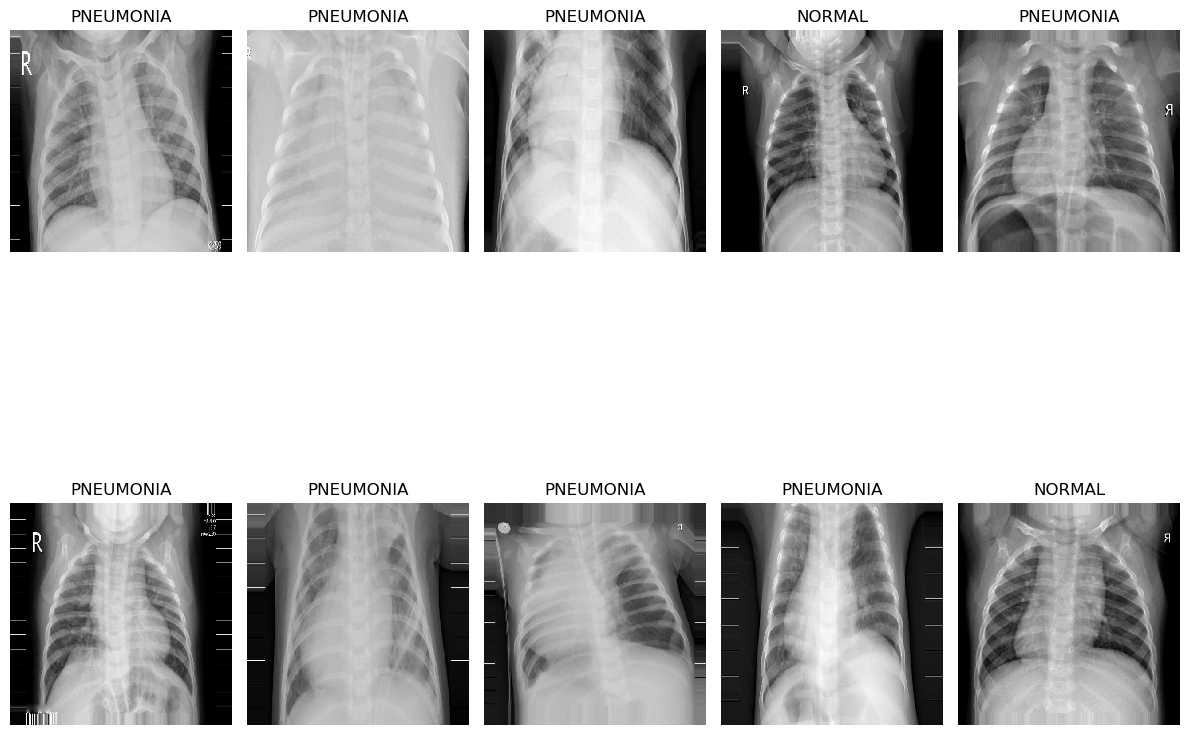

In [4]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image), cmap='gray', interpolation = 'nearest')
        break
plt.tight_layout()
plt.show()

## Convolutional Neural Network

In [5]:
#Necessary imports

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

### CNN Architecture

CNN Architecture
Things to note before starting to build a CNN model:-

Always begin with a lower filter value such as 32 and begin to increase it layer wise.

Construct the model with a layer of Conv2D followed by a layer of MaxPooling.

The kernel_size is preferred to be odd number like 3x3.

Tanh, relu, etc. can be used for activation function, but relu is the most preferred activation function.

input_shape takes in image width & height with last dimension as color channel.

Flattening the input after CNN layers and adding ANN layers.

Use activation function as softmax for the last layer If the problem is more than 2 classes, define units as the total number of 
classes and use sigmoid for binary classification and set unit to 1.

<b>We can always experiment with these hyperparameters as there is no fixed value on which we can settle.</b>

In [6]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Now we’ve developed the CNN model, let’s see in depth what’s going on here

In [7]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

### Interpreting Model Summary

https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

<b>Filters:</b> 
Is the number of filters that the convolutional layer will learn.
Layers early in the network architecture (i.e., closer to the actual input image) learn fewer convolutional filters while layers deeper in the network (i.e., closer to the output predictions) will learn more filters.
Conv2D layers in between will learn more filters than the early Conv2D layers but fewer filters than the layers closer to the output

<b>kernel_size: </b> 
kernel_size is a 2-tuple specifying the width and height of the 2D convolution window.
The kernel_size must be an odd integer as well.
Typical values for kernel_size include: (1, 1) , (3, 3) , (5, 5) , (7, 7) . It’s rare to see kernel sizes larger than 7×7.
So, when do you use each?
If your input images are greater than 128×128 (our case) you may choose to use a kernel size > 3 to help (1) learn larger spatial filters and (2) to help reduce volume size.

<b>strides:</b> 
The strides value defaults to (1, 1) implying that:
 - A given convolutional filter is applied to the current location of the input volume
 - The filter takes a 1-pixel step to the right and again the filter is applied to the input volume
 - This process is performed until we reach the far-right border of the volume in which we move our filter one pixel down and then start again from the far left.
Typically you’ll leave the strides parameter with the default (1, 1) value; however, you may occasionally increase it to (2, 2) to help reduce the size of the output volume (since the step size of the filter is larger).

<b>padding: </b>
The padding parameter to the Keras Conv2D class can take on one of two values: valid or same.
With the valid parameter the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.

<b> Activation: </b>
Is a function that is added to an artificial neural network to help the network learn complex patterns in the data. When comparing with a neuron-based model in our brains, the activation function is at the end of the day to decide what to do with the next neuron. Since the classification is between 2 classes we are going to use sigmoid activation function for last layer which returns value in the range of 0 to 1. For more than 2 classes we can use softmax activation function.

In [8]:
# Hyperparameters of Conv2D
Conv2D(
    filters = 32,
    kernel_size = (3, 3),
    strides = (1, 1),
    padding = "valid",
    activation = "sigmoid",
    input_shape = (500, 500, 1)
    )
# Hyperparameters of MaxPooling2D 
MaxPooling2D(
    pool_size = (2, 2), strides = None, padding = "valid"
    )




### Visualize CNN model

In [9]:
#pip install pydot

In [10]:
#from tensorflow.keras.utils import plot_model
#plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Fit the model

<b>Defining Callback list</b>

EarlyStopping is called to stop the epochs based on some metric(monitor) and conditions (mode, patience) . It helps to avoid overfitting the model. Over here we are telling to stop based on val_loss metric, we need it to be minimum. patience says that after a minimum val_loss is achieved then after that in next iterations if the val_loss increases in any the 3 iterations then the the training will stop at that epoch.

Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2–10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced

In [12]:
early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 1,factor = 0.3, min_lr = 0.000001)
callbacks_list = [early, learning_rate_reduction]

<b>Assigning Class Weights</b>

It is good practice to assign class weights for each class. It emphasizes the weight of the minority class in order for the model to learn from all classes equally.

In [20]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train.classes),
                                        y = train.classes                                                    
                                    )
cw = dict(zip(np.unique(train.classes), weights))
cw

{0: 1.9371534195933457, 1: 0.6739549839228296}

## Trainning

The parameters we are passing to model.fit are train set, epochs as 25, validation set used to calculate val_loss and val_accuracy, class weights and callback list

In [21]:
cnn.fit(train,epochs = 25, validation_data = valid, class_weight = cw, callbacks = callbacks_list)

Epoch 1/25
262/262 [==============================] - 317s 1s/step - loss: 0.5317 - accuracy: 0.6608 - val_loss: 0.2571 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 2/25
262/262 [==============================] - 301s 1s/step - loss: 0.2522 - accuracy: 0.8991 - val_loss: 0.1706 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 3/25
262/262 [==============================] - 301s 1s/step - loss: 0.2088 - accuracy: 0.9091 - val_loss: 0.2167 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 4/25
262/262 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9120
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
262/262 [==============================] - 299s 1s/step - loss: 0.2047 - accuracy: 0.9120 - val_loss: 0.2051 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 5/25
262/262 [==============================] - 298s 1s/step - loss: 0.1482 - accuracy: 0.9437 - val_loss: 0.1842 - val_accuracy: 0.9279 - lr: 3.0000e-04


## Evaluate

Let’s visualize the progress of all metrics throughout the total epochs lifetime

<AxesSubplot:>

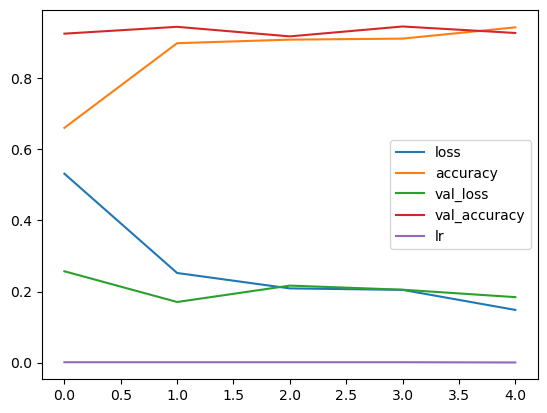

In [22]:
pd.DataFrame(cnn.history.history).plot()

In [23]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 13s 327ms/step - loss: 0.2948 - accuracy: 0.9087
The testing accuracy is : 90.86538553237915 %
